In [0]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [0]:
from fastai.vision import *
from fastai.metrics import error_rate

## Setup Paths, Mount GDrive
This is where the dataset is

In [3]:
import os

# Load the Drive helper and mount
from google.colab import drive

# This will prompt for authorization.
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/gdrive


In [4]:
cd '/content/gdrive/My Drive'

/content/gdrive/My Drive


In [5]:
# Set the path where the datasets are
path_data = Path('./datasets'); path_data

PosixPath('datasets')

In [6]:
path_data.ls()

[PosixPath('datasets/tomato_ripe'),
 PosixPath('datasets/tomato_rotten'),
 PosixPath('datasets/tomato_unripe'),
 PosixPath('datasets/not_tomato')]

## Create the ImageDataBunch object

In [0]:
bs = 64
data = ImageDataBunch.from_folder(path_data, valid_pct=0.2, 
                                  ds_tfms=get_transforms(), size=224, bs=bs).normalize(imagenet_stats)

In [8]:
data

ImageDataBunch;

Train: LabelList (488 items)
x: ImageList
Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224)
y: CategoryList
tomato_ripe,tomato_ripe,tomato_ripe,tomato_ripe,tomato_ripe
Path: datasets;

Valid: LabelList (122 items)
x: ImageList
Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224)
y: CategoryList
not_tomato,not_tomato,tomato_ripe,tomato_ripe,tomato_unripe
Path: datasets;

Test: None

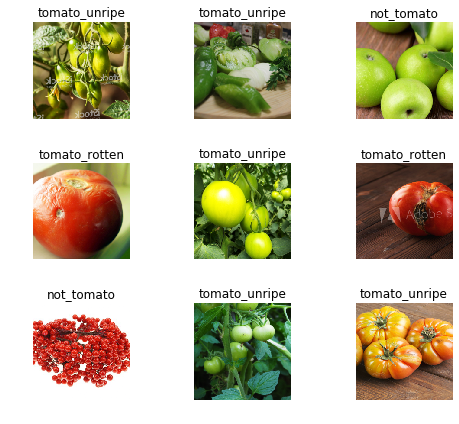

In [9]:
data.show_batch(rows=3, figsize=(7,6))

In [10]:
print(data.classes)
len(data.classes),data.c

['not_tomato', 'tomato_ripe', 'tomato_rotten', 'tomato_unripe']


(4, 4)

## Train

In [38]:
learn = cnn_learner(data, models.resnet18, metrics=error_rate)

Downloading: "https://download.pytorch.org/models/resnet18-5c106cde.pth" to /root/.cache/torch/checkpoints/resnet18-5c106cde.pth
100%|██████████| 46827520/46827520 [00:00<00:00, 69937754.80it/s]


In [39]:
learn.model

Sequential(
  (0): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (rel

In [40]:
learn.loss_func

FlattenedLoss of CrossEntropyLoss()

In [41]:
learn.fit_one_cycle(10)

epoch,train_loss,valid_loss,error_rate,time
0,1.643853,1.387327,0.688525,00:28
1,1.327436,0.788416,0.319672,00:28
2,1.041167,0.513534,0.188525,00:28
3,0.835016,0.462697,0.155738,00:30
4,0.696591,0.422760,0.147541,00:29
5,0.599930,0.431764,0.163934,00:29
6,0.526156,0.404243,0.147541,00:29
7,0.468015,0.393769,0.139344,00:28
8,0.423946,0.392564,0.131148,00:30
9,0.385486,0.392652,0.131148,00:29


In [0]:
learn.save('resnet18_10epochs')

In [43]:
interp = ClassificationInterpretation.from_learner(learn)

losses,idxs = interp.top_losses()

len(data.valid_ds)==len(losses)==len(idxs)

True

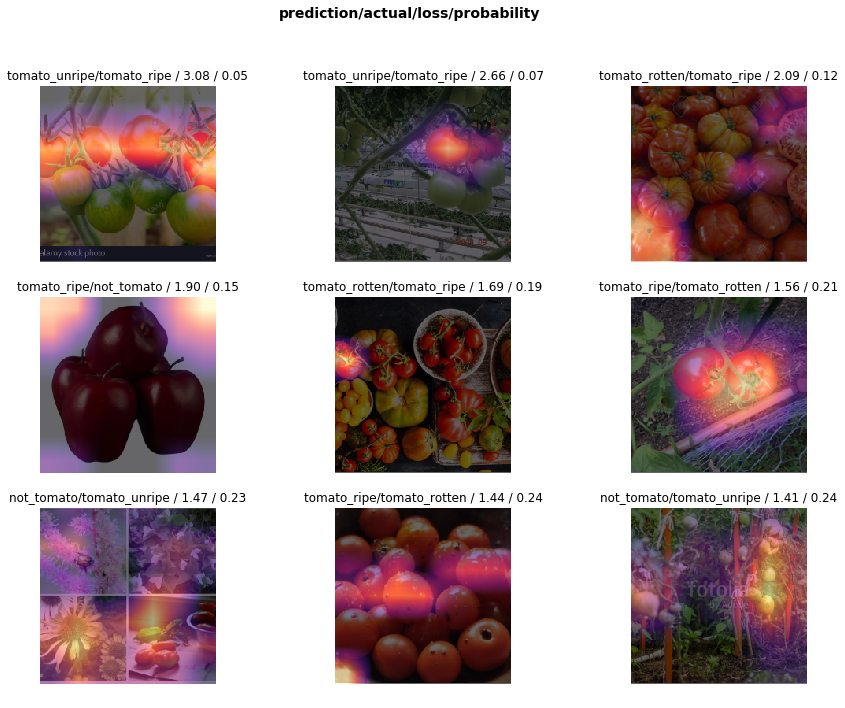

In [18]:
interp.plot_top_losses(9, figsize=(15,11))

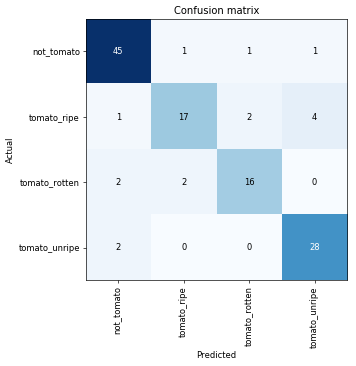

In [44]:
interp.plot_confusion_matrix(figsize=(6,6), dpi=60)

In [35]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


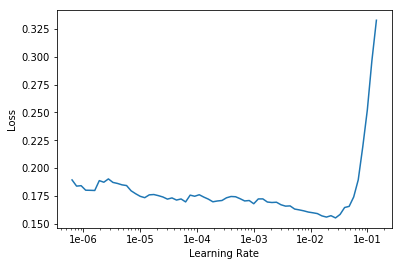

In [36]:
learn.recorder.plot()

In [0]:
learn.load('resnet34_4epochs')

In [45]:
learn.unfreeze()
learn.fit_one_cycle(10, max_lr=slice(1e-5,2e-3))

epoch,train_loss,valid_loss,error_rate,time
0,0.174981,0.402133,0.122951,00:29
1,0.167330,0.441753,0.147541,00:30
2,0.160906,0.417347,0.114754,00:30
3,0.154131,0.423366,0.106557,00:29
4,0.136199,0.468203,0.114754,00:29
5,0.124229,0.351054,0.098361,00:28
6,0.109857,0.364842,0.090164,00:29
7,0.097200,0.372348,0.090164,00:29
8,0.085867,0.377502,0.090164,00:29
9,0.078845,0.373741,0.090164,00:29


In [26]:
learn.fit_one_cycle(10, max_lr=slice(1e-4,8e-3))

epoch,train_loss,valid_loss,error_rate,time
0,0.163116,0.631502,0.139344,00:30
1,0.132522,0.662274,0.180328,00:30
2,0.116053,0.881901,0.147541,00:31
3,0.132117,1.828211,0.270492,00:31
4,0.152375,1.208970,0.213115,00:29
5,0.156666,1.074139,0.196721,00:29
6,0.153745,1.085565,0.188525,00:29
7,0.167951,0.524763,0.131148,00:31
8,0.149552,0.441545,0.147541,00:29
9,0.133365,0.409613,0.139344,00:32


In [0]:
learn.save('resnet18_10_10epochs_err09')